# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://course.cse.ust.hk/comp4901j/Password_Only/programs/assignment1/index.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [29]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [31]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.349440
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** We expect our loss to be close to -log(0.1) because we expect that the classes are equally likely to be chosen. Since CIFAR-10 consists of samples of ten classes, the probability of the correct class will be 1/10 = 0.1. The softmax loss is therefore -log(0.1).


In [32]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -2.334127 analytic: -2.334127, relative error: 1.193094e-08
numerical: -0.353507 analytic: -0.353507, relative error: 6.242834e-08
numerical: -1.874904 analytic: -1.874904, relative error: 2.611086e-08
numerical: -2.013269 analytic: -2.013269, relative error: 1.478502e-08
numerical: 1.154694 analytic: 1.154694, relative error: 9.519545e-09
numerical: -0.334328 analytic: -0.334328, relative error: 6.550687e-08
numerical: 0.415043 analytic: 0.415043, relative error: 3.744410e-08
numerical: -0.052384 analytic: -0.052384, relative error: 9.665608e-08
numerical: 0.450806 analytic: 0.450806, relative error: 3.412266e-08
numerical: -3.381060 analytic: -3.381060, relative error: 6.346168e-09
numerical: 0.202786 analytic: 0.202786, relative error: 2.729038e-07
numerical: 0.447578 analytic: 0.447578, relative error: 1.607180e-09
numerical: -1.064629 analytic: -1.064629, relative error: 2.387686e-08
numerical: 0.499873 analytic: 0.499873, relative error: 8.448659e-08
numerical: 0.07332

In [33]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.349440e+00 computed in 0.045014s
vectorized loss: 2.349440e+00 computed in 0.003001s
Loss difference: 0.000000
Gradient difference: 0.000000


In [34]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-8, 2e-7, 1e-7, 2e-6, 3e-5]
regularization_strengths = [0.5e3, 1e3, 0.5e4, 1e4, 2e4, 2.5e4, 3e4, 3.5e4, 4e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
iters = 1500

for rs in learning_rates:
    for lr in regularization_strengths:
        softmax_model = Softmax()
        loss_hist = softmax_model.train(X_train, y_train, lr, rs, num_iters = iters)
        y_train_pred = softmax_model.predict(X_train)
        train_accuracy = np.mean([y_train_pred == y_train])
        y_val_pred = softmax_model.predict(X_val)
        val_accuracy = np.mean([y_val_pred == y_val])
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_softmax = softmax_model
        results[(lr, rs)] = train_accuracy, val_accuracy
        
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

C:\Users\vodxac\Desktop\WPy-3662\notebooks\assignment1\cs231n\classifiers\softmax.py:82: RuntimeWarning: divide by zero encountered in log
  exp_sum = np.sum(exp_scores, axis = 1).reshape((num_train, -1))
C:\Users\vodxac\Desktop\WPy-3662\python-3.6.6.amd64\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
C:\Users\vodxac\Desktop\WPy-3662\notebooks\assignment1\cs231n\classifiers\softmax.py:90: RuntimeWarning: overflow encountered in multiply
  loss += reg * np.sum(W * W)


lr 5.000000e+02 reg 1.000000e-08 train accuracy: 0.284224 val accuracy: 0.270000
lr 5.000000e+02 reg 1.000000e-07 train accuracy: 0.313367 val accuracy: 0.301000
lr 5.000000e+02 reg 2.000000e-07 train accuracy: 0.270265 val accuracy: 0.290000
lr 5.000000e+02 reg 2.000000e-06 train accuracy: 0.269592 val accuracy: 0.281000
lr 5.000000e+02 reg 3.000000e-05 train accuracy: 0.208204 val accuracy: 0.212000
lr 1.000000e+03 reg 1.000000e-08 train accuracy: 0.296327 val accuracy: 0.276000
lr 1.000000e+03 reg 1.000000e-07 train accuracy: 0.325490 val accuracy: 0.314000
lr 1.000000e+03 reg 2.000000e-07 train accuracy: 0.302122 val accuracy: 0.284000
lr 1.000000e+03 reg 2.000000e-06 train accuracy: 0.265776 val accuracy: 0.262000
lr 1.000000e+03 reg 3.000000e-05 train accuracy: 0.221429 val accuracy: 0.242000
lr 5.000000e+03 reg 1.000000e-08 train accuracy: 0.328041 val accuracy: 0.343000
lr 5.000000e+03 reg 1.000000e-07 train accuracy: 0.280816 val accuracy: 0.278000
lr 5.000000e+03 reg 2.000000

In [35]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.315000


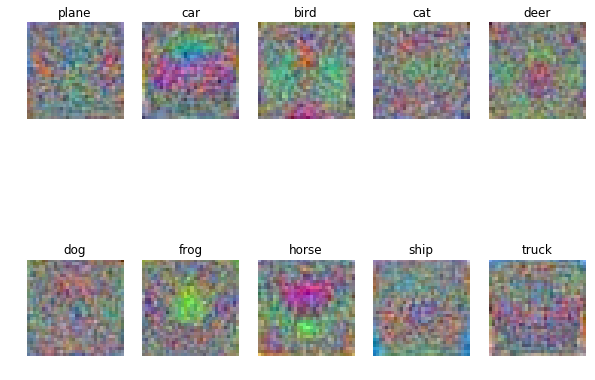

In [36]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])